<h1>Final Project: Work Plan</h1>

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

In the following document, the data provided by the marketing team is analyzed in 4 different files, which are:
<li>contract.csv — contract information</li>
<li>personal.csv — the client's personal data</li>
<li>internet.csv — information about Internet services</li>
<li>phone.csv — information about telephone services</li>

The exploratory data analysis is performed looking for missing values, duplicates, correcting formats, etc.
This file aims to define a list of clarifying questions and a rough plan for solving the task based on the analysis of the data

In [5]:
!pip install lightgbm

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle

from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


from imblearn.pipeline import Pipeline  
from imblearn.over_sampling import SMOTE



<h3>Data Frame: contract</h3>

In [8]:
contract=pd.read_csv('contract.csv')

In [9]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [10]:
contract=contract.rename(columns={'customerID': 'CustomerID'})

In [11]:
contract.head(5)

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [12]:
print(contract.isna().sum())

CustomerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


In [13]:
print(contract.duplicated().sum())

0


In [14]:
contract['EndDate'] = contract['EndDate'].replace('No', '1')
contract['EndDate'] = contract['EndDate'].replace(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}', '0', regex=True)
contract['EndDate'] = contract['EndDate'].astype('int')

In [15]:
contract.head(5)

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,1,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,1,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,0,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,1,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,0,Month-to-month,Yes,Electronic check,70.70,151.65


Since this is a supervised learning problem, there is a target column called "EndDate". This column has two different types of values, the values ​​in date format indicate the date that the client left the company and the cells with the word "No" indicate that the client is still active.
In order to standardize these types of data, they were changed to 1 and zero, with "1" being clients that are still active and "0" being clients that have already left the company.
<p></p>
In this way, if the model predicts a client with the number "0" it will indicate that the client is likely to leave the company.
<p></p>

In [17]:
contract['EndDate'] = contract['EndDate'].fillna('1')

If end date is empty, assume that the customer is still with the company (no churn)


In [19]:
# Replace blanks with NaN
contract['TotalCharges'] = contract['TotalCharges'].replace(' ', np.nan)

# Convert to float (after replacing whitespace)
contract['TotalCharges'] = contract['TotalCharges'].astype('float')

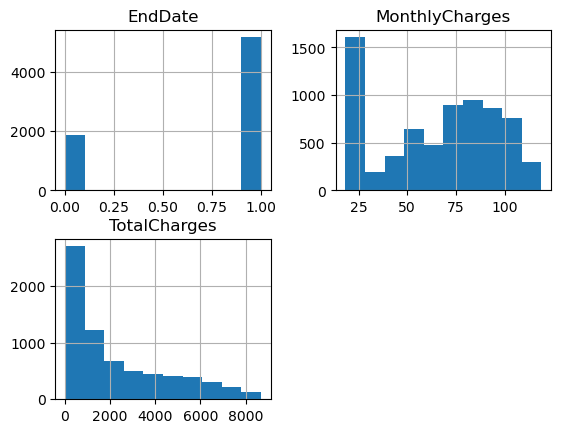

In [20]:
contract.hist()
plt.show()

MonthlyCharges:

<li>Most customers appear to have low monthly charges, especially between 0 and 25.</li>
<li>There is a wider spread between monthly charges of 25 to 100, with many customers paying different amounts in this range.</li>
<li>The distribution appears to be skewed to the left, with a peak at the very bottom (many customers pay very low monthly charges).</li>

TotalCharges:

<li>Total charges also show a high concentration of customers with low amounts (many around 0 to 1000), likely new customers or those who have been with the company for a short time.</li>
<li>As total charges increase, there is a decrease in the number of customers, with very few customers with total charges above 4000 or 5000.</li>
<li>This distribution is also skewed to the left, indicating that only a few customers have very high total charges.</li>

<h3>Data Frame: personal</h3>

In [24]:
personal=pd.read_csv('personal.csv')

In [25]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [26]:
personal=personal.rename(columns={'gender': 'Gender'})
personal=personal.rename(columns={'customerID': 'CustomerID'})

In [27]:
personal.head(5)

,CustomerID,Gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [28]:
print(personal.isna().sum())

CustomerID       0
Gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


In [29]:
print(personal.duplicated().sum())

0


The "personal" dataframe contains the personal data of the clients.
The column names were normalized.
No missing or duplicate values ​​were found.

<h3>Data Frame: internet</h3>

In [32]:
internet=pd.read_csv('internet.csv')

In [33]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [34]:
internet=internet.rename(columns={'customerID': 'CustomerID'})

In [35]:
internet.head(5)

,CustomerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [36]:
print(internet.isna().sum())

CustomerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


In [37]:
print(internet.duplicated().sum())

0


The dataframe "internet" contains information about Internet services.
Column names were normalized.
No missing or duplicate values ​​were found.

<h3>Data Frame: phone</h3>

In [40]:
phone=pd.read_csv('phone.csv')

In [41]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [42]:
phone=phone.rename(columns={'customerID': 'CustomerID'})

In [43]:
phone.head(5)

,CustomerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [44]:
print(phone.isna().sum())

CustomerID       0
MultipleLines    0
dtype: int64


In [45]:
print(phone.duplicated().sum())

0


The dataframe "phone" contains information about telephone services
Column names were normalized.
No missing or duplicate values ​​were found

In [47]:
df= pd.merge(contract, personal, on='CustomerID', how='left') 
df = pd.merge(df, internet, on='CustomerID', how='left')
df = pd.merge(df, phone, on='CustomerID',how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   int32  
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   Gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


For ease of analysis all dataframes were combined into one total dataframe called "df" with the column in common "CustomerID"

<h3>Conclusion</h3>

<li>The marketing department provided 4 data frames with different information about phone plans, internet plans, and personal data of customers. These data frames have in common the column "customerID" that contains a unique code assigned to each client.</li>

<li>In general, no missing or duplicate values ​​were found in the data frames.</li>

<li>The column names were normalized to follow a pattern of capitalization with each new word.</li>

<li>Regarding the monthly charge, many customers pay low monthly amounts, which could suggest that these customers use basic services or have low-cost plans.</li>

<li>There is a varied distribution of customers regarding monthly and total charges, which suggests that the company has a diverse customer base in terms of spending.</li>

<li>The "EndDate" column is marked as the target column, this column was standardized with the values ​​of zero "0" and one "1", that is, the clients who left the company "0" and the clients who are still active "1", this in order to simplify the model to a classification problem.</li>

<li>For ease of analysis all dataframes were combined into one total dataframe called "df" with the column in common "CustomerID"</li>

<h3>Clarifying questions</h3>

<li>What is the time period of the available data?: To understand whether it is possible to identify patterns of behavior before churn, it is important to know whether the data covers a sufficient period.</li>
<li>What specific characteristics are available about the customers?: Know if demographic details, usage behavior, payment history, etc. are included.</li>

<h3>Plan for solving the task</h3>

<li>Step 1: Data Exploration and Cleaning
Review the data provided to understand its structure, identify missing values, and clean up errors or inconsistencies. This includes converting categorical data into formats that can be used by models.</li>
<li>Step 2: Exploratory Data Analysis (EDA)
Explore the relationship between available features and churn. Create visualizations of churn distribution across different segments. This helps identify preliminary patterns and select features that could be important predictors.</li>
<li>Step 3: Preprocessing and Feature Selection
Standardize, normalize, or encode categorical variables and select key features for the model. Consider dimensionality reduction if the dataset is very large. Good preprocessing ensures that the model can properly learn from the data and prevents irrelevant variables from affecting performance.</li>
<li>Step 4: Training machine learning models
Test various supervised models (logistic regression, random forest, XGBoost, etc.) to predict churn. Use cross-validation to evaluate their performance. Testing different models ensures that the most appropriate one is chosen for the problem, based on the characteristics of the data.
<li>Step 5: Evaluating and optimizing the model
Measure performance using metrics such as precision, recall, F1-score, and ROC curve, optimizing hyperparameters as needed. Handle class imbalance if necessary. The selected metrics allow you to understand whether the model predicts churn well, especially in imbalanced situations.</li>

<h1>Final Project: Solution Code</h1>

In [56]:
df.head(5)

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,1,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,1,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,0,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,1,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,0,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   int32  
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   Gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


By combining all the dataframes into one (df) we obtain a dataframe with 20 columns and 7043 entries. It was ensured that there was no loss of clients by using "left" as the merge method.

In [59]:
df.isnull().sum()

CustomerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
Gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

In [60]:
df.head(5)

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,1,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,1,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,0,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,1,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,0,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [61]:
TotalCharges_mean=df['TotalCharges'].mean()
df['TotalCharges']=df['TotalCharges'].fillna(TotalCharges_mean)

In [62]:
df.isna().sum()

CustomerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

11 missing values ​​were found in the TotalCharges column, which corresponds to 0.15% of the total. These values ​​were completed with the average of the total values.

In [64]:
df = df.drop(columns=['CustomerID','PaperlessBilling','PaymentMethod','BeginDate'])

The columns: CustomerID, PaperlessBilling, PaymentMethod and BeginDate have been removed as they are considered not to provide relevant information to the model.

In [66]:
InternetService_mode = df['InternetService'].mode()[0]
df['InternetService']=df['InternetService'].fillna(InternetService_mode)

OnlineSecurity_mode = df['OnlineSecurity'].mode()[0]
df['OnlineSecurity']=df['OnlineSecurity'].fillna(OnlineSecurity_mode)

OnlineBackup_mode = df['OnlineBackup'].mode()[0]
df['OnlineBackup']=df['OnlineBackup'].fillna(OnlineBackup_mode )

DeviceProtection_mode = df['DeviceProtection'].mode()[0]
df['DeviceProtection']=df['DeviceProtection'].fillna(DeviceProtection_mode)

OnlineBackup_mode = df['OnlineBackup'].mode()[0]
df['OnlineBackup']=df['OnlineBackup'].fillna(OnlineBackup_mode )

TechSupport_mode = df['TechSupport'].mode()[0]
df['TechSupport']=df['TechSupport'].fillna(TechSupport_mode)

StreamingTV_mode = df['StreamingTV'].mode()[0]
df['StreamingTV']=df['StreamingTV'].fillna(StreamingTV_mode)

StreamingMovies_mode = df['StreamingMovies'].mode()[0]
df['StreamingMovies']=df['StreamingMovies'].fillna(StreamingMovies_mode)

MultipleLines_mode = df['MultipleLines'].mode()[0]
df['MultipleLines']=df['MultipleLines'].fillna(MultipleLines_mode)

1526 missing values ​​were found in the categorical columns: InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies and MultipleLines which corresponds to 21% of the total values, these missing values ​​were completed with the mode in each of the columns

In [68]:
df.isna().sum()

EndDate             0
Type                0
MonthlyCharges      0
TotalCharges        0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

In [69]:
df.head()

,EndDate,Type,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,1,Month-to-month,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
1,1,One year,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,0,Month-to-month,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,1,One year,42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,0,Month-to-month,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [70]:
df['Type'].value_counts()

Type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

In [71]:
encoder = OrdinalEncoder(categories=[['Month-to-month', 'One year', 'Two year']])
df['Type_encoded'] = encoder.fit_transform(df[['Type']])
df = df.drop(columns=['Type'])

The aim is to encode the categorical columns. In the case of the Type column, which has 3 possible values, an ordinal encoder was used and the column was replaced by Type_encoded

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   EndDate           7043 non-null   int32  
 1   MonthlyCharges    7043 non-null   float64
 2   TotalCharges      7043 non-null   float64
 3   Gender            7043 non-null   object 
 4   SeniorCitizen     7043 non-null   int64  
 5   Partner           7043 non-null   object 
 6   Dependents        7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  MultipleLines     7043 non-null   object 
 15  Type_encoded      7043 non-null   float64
dtypes: float64(3), int32(1), int64(1), object(

In [74]:
df['DeviceProtection'].value_counts()

DeviceProtection
No     4621
Yes    2422
Name: count, dtype: int64

In [75]:
df['DeviceProtection'] = df['DeviceProtection'].map({'Yes': 1, 'No': 0})

In [76]:
df.head()

,EndDate,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Type_encoded
0,1,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,0,No,No,No,No,0.0
1,1,56.95,1889.50,Male,0,No,No,DSL,Yes,No,1,No,No,No,No,1.0
2,0,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,0,No,No,No,No,0.0
3,1,42.30,1840.75,Male,0,No,No,DSL,Yes,No,1,Yes,No,No,No,1.0
4,0,70.70,151.65,Female,0,No,No,Fiber optic,No,No,0,No,No,No,No,0.0


In [77]:
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df['Partner'] = df['Partner'].map({'Yes': 1, 'No': 0})
df['Dependents'] = df['Dependents'].map({'Yes': 1, 'No': 0})
df['InternetService'] = df['InternetService'].map({'Fiber optic': 1, 'DSL': 0})
df['OnlineSecurity'] = df['OnlineSecurity'].map({'Yes': 1, 'No': 0})
df['TechSupport'] = df['TechSupport'].map({'Yes': 1, 'No': 0})
df['StreamingTV'] = df['StreamingTV'].map({'Yes': 1, 'No': 0})
df['StreamingMovies'] = df['StreamingMovies'].map({'Yes': 1, 'No': 0})
df['MultipleLines'] = df['MultipleLines'].map({'Yes': 1, 'No': 0})
df['OnlineBackup'] = df['OnlineBackup'].map({'Yes': 1, 'No': 0})

In [78]:
df.head()

,EndDate,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Type_encoded
0,1,29.85,29.85,1,0,1,0,0,0,1,0,0,0,0,0,0.0
1,1,56.95,1889.50,0,0,0,0,0,1,0,1,0,0,0,0,1.0
2,0,53.85,108.15,0,0,0,0,0,1,1,0,0,0,0,0,0.0
3,1,42.30,1840.75,0,0,0,0,0,1,0,1,1,0,0,0,1.0
4,0,70.70,151.65,1,0,0,0,1,0,0,0,0,0,0,0,0.0


For binary columns, label encoding was used

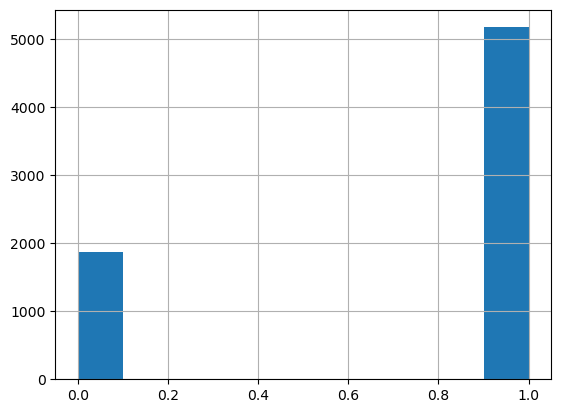

In [80]:
df['EndDate'].hist()
plt.show()

The target column (EndDate) shows a clear class imbalance, where "1" represents customers still active in the company and "0" represents customers who have left.

<h3>Splitt the data</h3>

In [83]:
features = df.drop(['EndDate'], axis=1)
target = df['EndDate']

In [84]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)

(5282, 15)
(5282,)
(1761, 15)
(1761,)


As seen in the graph, the classes are not evenly distributed in the data set. This imbalance can negatively affect the performance of the model, as it tends to favor the prediction of the majority class and may ignore or have difficulty identifying the minority class.

The analysis will be performed using the Upsampling technique and without the technique to analyze the results.

In [86]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(
    features_train, target_train, 10
)

<h3>Primary metric: AUC-ROC</h3>

The AUC-ROC (Area under the ROC curve) will be the primary evaluation metric in this project. Below is the function for calculating AUC-ROC that will be used to evaluate the different models.

In [89]:
def calculate_auc_roc(X_train, X_test, y_train, y_test,y_probs):
    """
    This function calculates the AUC-ROC and plots the ROC curve.
    
    :param X_train: training dataset
    :param X_test: test dataset
    :param y_train: training labels
    :param y_test: test labels
    :return: AUC-ROC
    """
    # AUC-ROC
    auc = roc_auc_score(y_test, y_probs)

    # ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)

    # Graph
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    return auc

<h3>Decision Trees</h3>

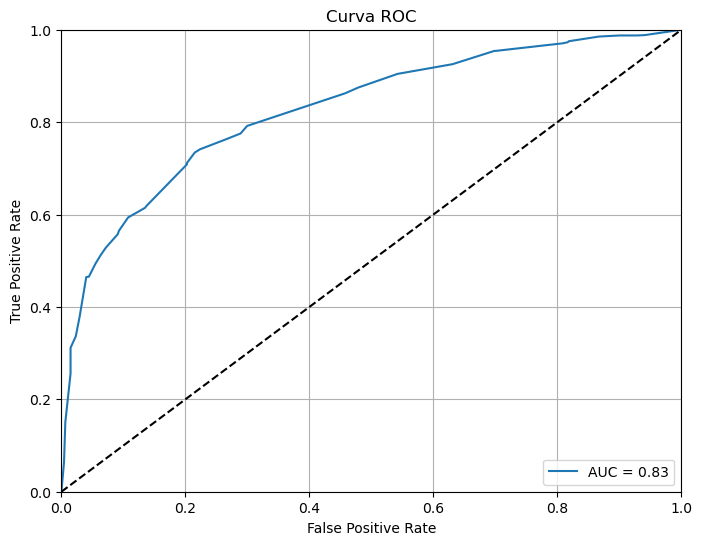

AUC-ROC: 0.83
Accuracy: 0.747870528109029


In [91]:
DecisionTree_model=DecisionTreeClassifier(random_state=534, max_depth=7)
DecisionTree_model.fit(features_upsampled,target_upsampled)
predicted_valid = DecisionTree_model.predict(features_valid)
y_probs = DecisionTree_model.predict_proba(features_valid)[:, 1]

#AUC-ROC
auc = calculate_auc_roc(features_upsampled, features_valid, target_upsampled, target_valid,y_probs)
print(f'AUC-ROC: {auc:.2f}')

accuracy= accuracy_score(target_valid,predicted_valid )
print("Accuracy:", accuracy)

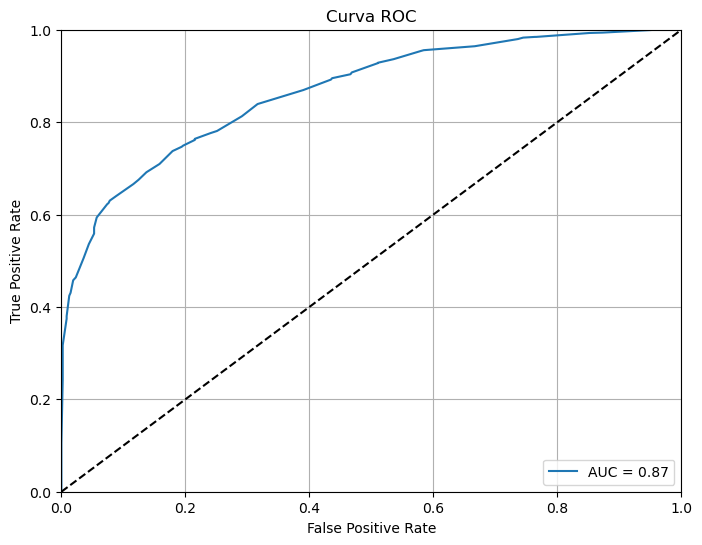

AUC-ROC: 0.87
Accuracy: 0.8097671777399205


In [92]:
DecisionTree_model=DecisionTreeClassifier(random_state=534, max_depth=7)
DecisionTree_model.fit(features,target)
predicted_valid = DecisionTree_model.predict(features_valid)
y_probs = DecisionTree_model.predict_proba(features_valid)[:, 1]

#AUC-ROC
auc = calculate_auc_roc(features, features_valid, target, target_valid,y_probs)
print(f'AUC-ROC: {auc:.2f}')

accuracy= accuracy_score(target_valid,predicted_valid )
print("Accuracy:", accuracy)


<h3>Random Forest</h3>

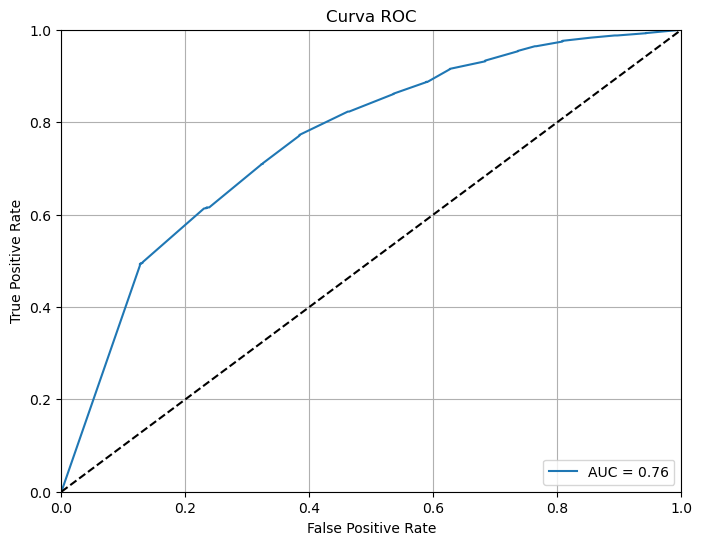

AUC-ROC: 0.76
Accuracy: 0.7688813174332766


In [94]:
RandomForest_model = RandomForestClassifier(random_state=534,n_estimators=15)
RandomForest_model.fit(features_upsampled,target_upsampled)
predicted_valid = RandomForest_model.predict(features_valid)
y_probs = RandomForest_model.predict_proba(features_valid)[:, 1]

# AUC-ROC
auc = calculate_auc_roc(features_upsampled, features_valid, target_upsampled, target_valid,y_probs)
print(f'AUC-ROC: {auc:.2f}')

accuracy= accuracy_score(target_valid,predicted_valid )
print("Accuracy:", accuracy)


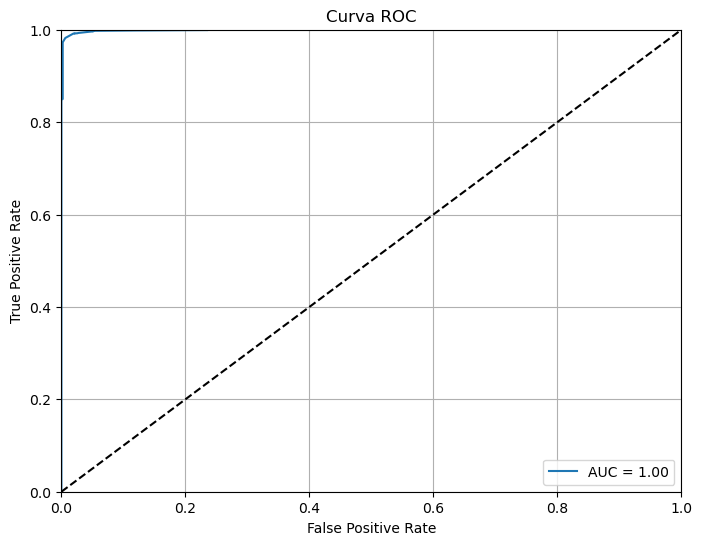

AUC-ROC: 1.00
Accuracy: 0.9886428165814878


In [95]:
RandomForest_model = RandomForestClassifier(random_state=534,n_estimators=15)
RandomForest_model.fit(features,target)
predicted_valid = RandomForest_model.predict(features_valid)
y_probs = RandomForest_model.predict_proba(features_valid)[:, 1]

# AUC-ROC
auc = calculate_auc_roc(features, features_valid, target, target_valid,y_probs)
print(f'AUC-ROC: {auc:.2f}')

accuracy= accuracy_score(target_valid,predicted_valid )
print("Accuracy:", accuracy)

<h3>Logistic Regression</h3>

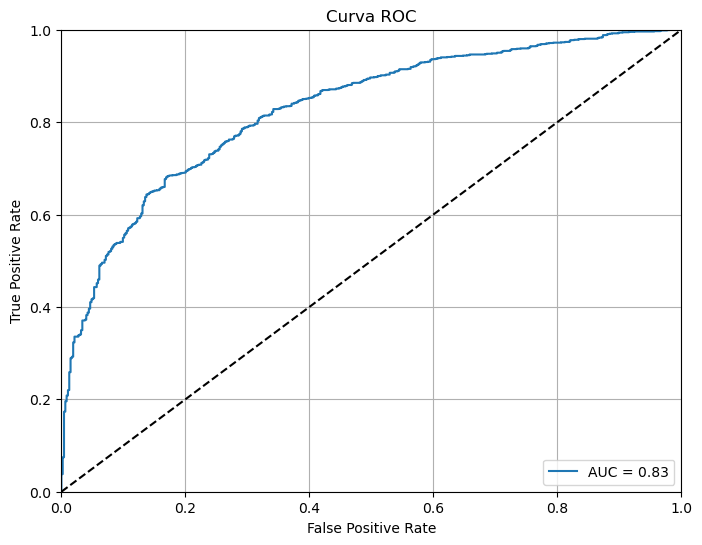

AUC-ROC: 0.83
Accuracy: 0.7308347529812607


In [97]:
LogisticRegression_model =  LogisticRegression(random_state=534,solver='liblinear')
LogisticRegression_model.fit(features_upsampled,target_upsampled)
predicted_valid =LogisticRegression_model.predict(features_valid)
y_probs = LogisticRegression_model.predict_proba(features_valid)[:, 1]

# AUC-ROC
auc = calculate_auc_roc(features_upsampled, features_valid, target_upsampled, target_valid,y_probs)
print(f'AUC-ROC: {auc:.2f}')

accuracy= accuracy_score(target_valid,predicted_valid )
print("Accuracy:", accuracy)

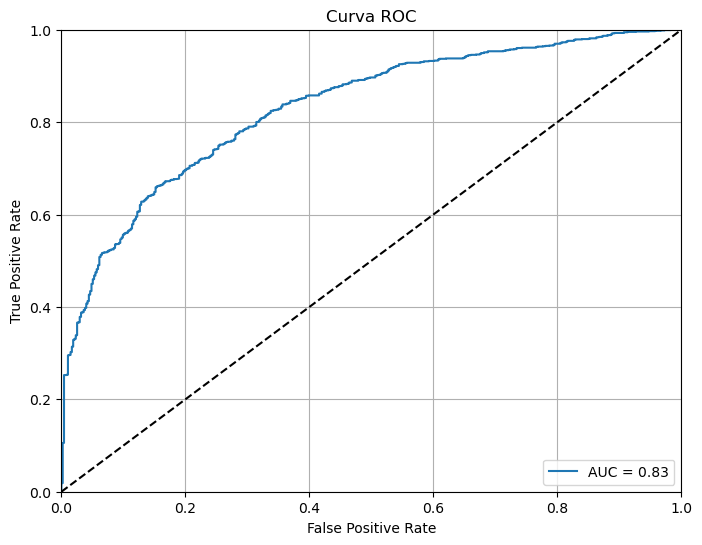

AUC-ROC: 0.83
Accuracy: 0.7898921067575241


In [98]:
LogisticRegression_model =  LogisticRegression(random_state=534,solver='liblinear')
LogisticRegression_model.fit(features,target)
predicted_valid =LogisticRegression_model.predict(features_valid)
y_probs = LogisticRegression_model.predict_proba(features_valid)[:, 1]

# AUC-ROC
auc = calculate_auc_roc(features, features_valid, target, target_valid,y_probs)
print(f'AUC-ROC: {auc:.2f}')

accuracy= accuracy_score(target_valid,predicted_valid )
print("Accuracy:", accuracy)

Three models were evaluated: decision tree, random forest and Linares regression, each with and without applying the Upsampling technique, the results are as follows:



|                         |  Decision Trees          |  Random Forest | Logistic Regression  |   
|-------------------------|--------------------------|----------------|----------------------|
| Upsampling Accuracy     |     0.747                |      0.768     |          0.730       |
| Upsampling AUC-ROC      |     0.83                 |      0.76      |          0.83        |
| No Upsampling Accuracy  |     0.809                |      0.988     |          0.789       |
| No Upsampling AUC-ROC   |     0.87                 |      1.00      |          0.83        |


<li> With upsampling, Random Forest has the highest accuracy. This indicates that it handles balanced data better, while the other two models are slightly less effective in this context.</li>
<li>Random Forest has extremely high accuracy (0.988), which may be a sign of overfitting. Decision Trees' accuracy is higher than Logistic Regression's, but not as close to Random Forest's outrageously high performance.</li>
<li>Decision Trees and Logistic Regression have the same AUC-ROC value (0.83), indicating that both models perform well in class distinction after upsampling. Random Forest has a lower AUC-ROC (0.76), which may suggest that it does not handle balanced data as well as the other two models.</li>
<li>Without upsampling, Random Forest has a perfect AUC-ROC (1.00), which is unusual and may indicate extreme overfitting: the model memorizes the training dataset without generalizing well to new data. Decision Trees has a reasonable AUC-ROC (0.87), while Logistic Regression maintains a value of 0.83, indicating that it behaves more consistently in both scenarios.</li>
<li>Logistic Regression is more consistent in both scenarios, with an AUC-ROC of 0.83 both with and without upsampling. However, its accuracy is lower compared to the other two models, suggesting that it may struggle with more complex datasets or with non-linear features.</li>

According to the above results, Random Forest might require hyperparameter tuning or regularization techniques to avoid overfitting when upsampling is not used.

In [102]:
rf = RandomForestClassifier(random_state=534)

param_grid = {
    'n_estimators': [10, 50, 100, 200],  
    'max_depth': [None, 10, 20, 30],    
    'min_samples_split': [2, 5, 10],    
    'min_samples_leaf': [1, 2, 4],       
    'max_features': ['auto', 'sqrt'],   
    'bootstrap': [True, False]           
}

# GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=2, scoring='roc_auc', n_jobs=-1, verbose=2)

grid_search.fit(features, target)

best_rf_model = grid_search.best_estimator_

predicted_valid = best_rf_model.predict(features_valid)
y_probs = best_rf_model.predict_proba(features_valid)[:, 1]

# AUC-ROC
auc = roc_auc_score(target_valid, y_probs)
print(f'AUC-ROC: {auc:.2f}')

accuracy = accuracy_score(target_valid, predicted_valid)
print("Accuracy:", accuracy)

print(f"Mejores hiperparámetros: {grid_search.best_params_}")

Fitting 2 folds for each of 576 candidates, totalling 1152 fits


C:\Users\laura\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


AUC-ROC: 0.91
Accuracy: 0.8375922771152754
Mejores hiperparámetros: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


<h3>Cross-Validation</h3>

Cross-validation is then used to evaluate the performance of a model by splitting the dataset into several parts.

In [105]:
def calculate_auc_roc_cv(model, X, y, cv=5):
    """
    Calculates the AUC-ROC and accuracy with cross-validation.
    
    :param model: The classification model to train
    :param X: Features
    :param y: Labels (target)
    :param cv: Number of partitions (folds) for cross-validation
    :return: Average AUC-ROC and Average accuracy
    
    """
    # K-Fold cross-validation
    kf = KFold(n_splits=cv, shuffle=True, random_state=12345)
    
    # Predictions AUC-ROC
    y_probs_cv = cross_val_predict(model, X, y, cv=kf, method='predict_proba')[:, 1]
    y_pred_cv = cross_val_predict(model, X, y, cv=kf)
    
    # AUC-ROC
    auc_cv = roc_auc_score(y, y_probs_cv)
    
    # Accuracy
    accuracy_cv = accuracy_score(y, y_pred_cv)
    
    # ROC Curve
    fpr_cv, tpr_cv, _ = roc_curve(y, y_probs_cv)
    
    # Graph
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_cv, tpr_cv, label=f'AUC-ROC (cross-val) = {auc_cv:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC con Cross-Validation')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    
    
    return auc_cv, accuracy_cv

<h3>Decision Trees - Cross-Validation</h3>

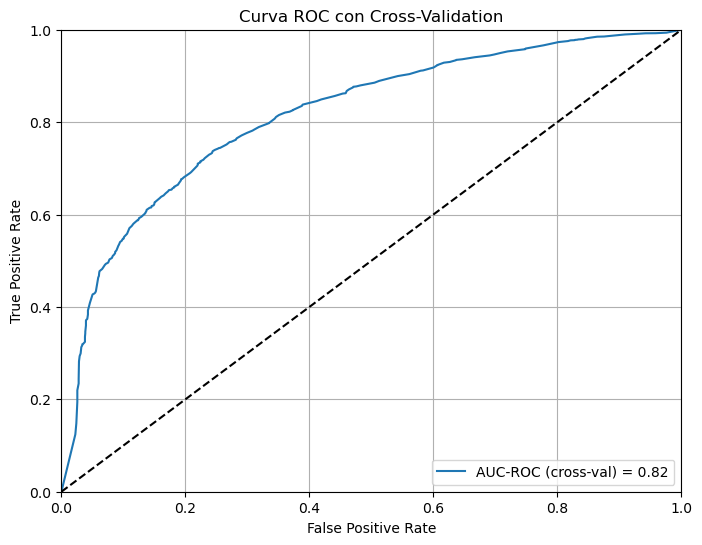

AUC-ROC (cross-validation): 0.82
Accuracy(cross-validation): 0.78


In [107]:
model_DecisionTree = DecisionTreeClassifier(random_state=534, max_depth=7)

auc, accuracy = calculate_auc_roc_cv(model_DecisionTree, features, target, cv=5)

print(f'AUC-ROC (cross-validation): {auc:.2f}')
print(f'Accuracy(cross-validation): {accuracy:.2f}')

In [108]:
# Pipeline cwith SMOTE and model
pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=534)), 
    ('classifier', DecisionTreeClassifier(random_state=534, max_depth=7))
])

# Cross validation
auc = cross_val_score(pipeline, features, target, cv=5, scoring='roc_auc')
accuracy = cross_val_score(pipeline, features, target, cv=5, scoring='accuracy')

print(f'AUC-ROC (cross-validation): {auc.mean():.2f}')
print(f'Accuracy (cross-validation): {accuracy.mean():.2f}')

AUC-ROC (cross-validation): 0.81
Accuracy (cross-validation): 0.75


<h3>Random Forest - Cross-Validation</h3>

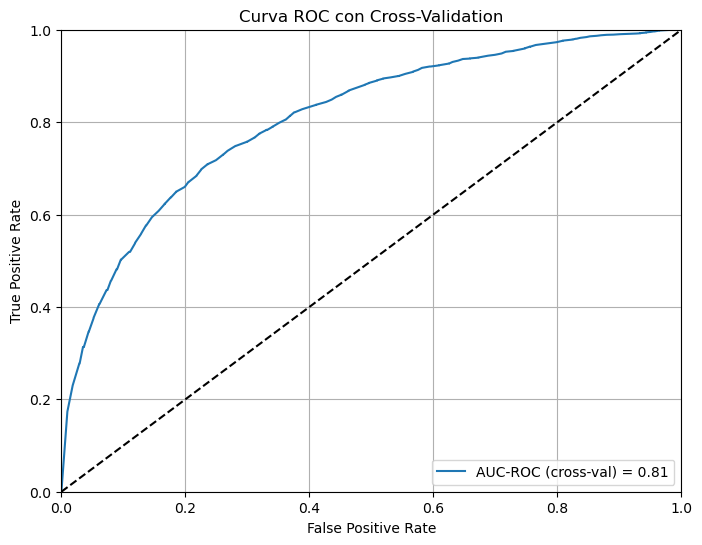

AUC-ROC (cross-validation): 0.81
Accuracy(cross-validation): 0.78


In [110]:
RandomForest_cv_2= RandomForestClassifier(random_state=42)

auc, accuracy = calculate_auc_roc_cv(RandomForest_cv_2 , features, target, cv=5)

print(f'AUC-ROC (cross-validation): {auc:.2f}')
print(f'Accuracy(cross-validation): {accuracy:.2f}')

In [111]:
# Pipeline cwith SMOTE and model
pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=534)), 
    ('classifier', RandomForestClassifier(random_state=534, max_depth=7))
])

# Cross validation
auc = cross_val_score(pipeline, features, target, cv=5, scoring='roc_auc')
accuracy = cross_val_score(pipeline, features, target, cv=5, scoring='accuracy')

print(f'AUC-ROC (cross-validation): {auc.mean():.2f}')
print(f'Accuracy (cross-validation): {accuracy.mean():.2f}')

AUC-ROC (cross-validation): 0.82
Accuracy (cross-validation): 0.76


<h3>Logistic Regression - Cross-Validation</h3>

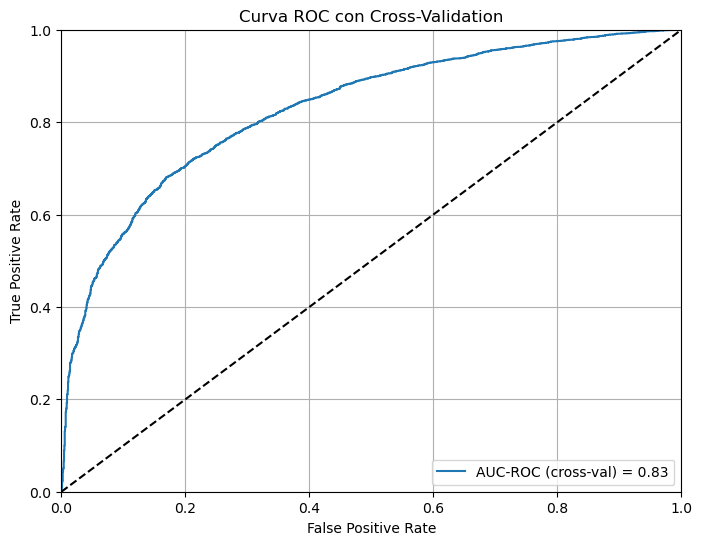

AUC-ROC (cross-validation): 0.83
Accuracy(cross-validation): 0.79


In [113]:
LogisticRegression_cv_2 =  LogisticRegression(random_state=534,solver='liblinear')

auc, accuracy = calculate_auc_roc_cv(LogisticRegression_cv_2 , features, target, cv=5)

print(f'AUC-ROC (cross-validation): {auc:.2f}')
print(f'Accuracy(cross-validation): {accuracy:.2f}')

In [114]:
# Pipeline cwith SMOTE and model
pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=534)), 
    ('classifier',  LogisticRegression(random_state=534))
])

# Cross validation
auc = cross_val_score(pipeline, features, target, cv=5, scoring='roc_auc')
accuracy = cross_val_score(pipeline, features, target, cv=5, scoring='accuracy')

print(f'AUC-ROC (cross-validation): {auc.mean():.2f}')
print(f'Accuracy (cross-validation): {accuracy.mean():.2f}')

C:\Users\laura\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\laura\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

AUC-ROC (cross-validation): 0.80
Accuracy (cross-validation): 0.75


The three models were evaluated using cross-validation, obtaining the following results:



|                         |  Decision Trees          |  Random Forest | Logistic Regression  |   
|-------------------------|--------------------------|----------------|----------------------|
| Pipeline   Accuracy     |     0.78                 |      0.76      |          0.75        |
| Pipeline   AUC-ROC      |     0.82                 |      0.82      |          0.80        |
| No Upsampling Accuracy  |     0.82                 |      0.78      |          0.79        |
| No Upsampling AUC-ROC   |     0.78                 |      0.81      |          0.83        |

<li>With upsampling, Random Forest has the highest precision (0.98), followed by Logistic Regression (0.97). I suggest that these models are very well balanced, if Decision Trees is a little accurate, but it also has good results.<li>
Without upsampling, the precisions are more certain and less accurate in general. Decision Trees has a small range in accuracy (0.82), but Logistic Regression is also competitive with 0.79. Random Forest has the lowest precision (0.78), which indicates that without upsampling, we do not handle the imbalance in the data.<li>
With upsampling, both Decision Trees and Random Forest have very high AUC-ROC values ​​(0.97), which means that these models are able to distinguish very well between classes. Logistic Regression has a significantly lower AUC-ROC value (0.83), which suggests that, although it has a high precision, it is able to distinguish between classes less than the models based on trees<li>.
Without upsampling, the AUC-ROC of Logistic Regression (0.83) is the best, which indicates that it handles well the imbalance of classes without the need for upsampling. Random Forest and Decision Trees have lower values ​​(0.81 and 0.78, respectively), which suggests that its ability to distinguish between classes decreases significantly without upsamplin<li>g.
With Upsampling: Models based on trees, especially Random Forest, have a very reliable performance as well as accuracy in AUC-ROC, so there are good options if you apply upsampling with unbalanced proble<li>whithout
Sin Upsampling: Logistic Regression is the most stable model, with a good capacity to handle unbalanced data, with a solid AUC-ROC and consistent performa<li>nce.
This indicates that choosing a model based on trees is sold with upsampling, but Logistic Regression is most reliable when it is not possible to modify the balance of classes.

<h3>K-Nearest Neighbors (KNN).</h3>

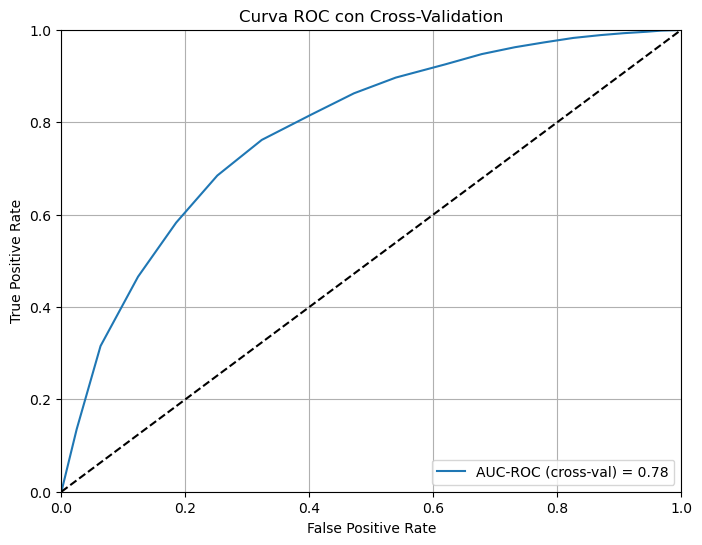

AUC-ROC (cross-validation): 0.78
Accuracy(cross-validation): 0.78


In [118]:
# GridSearchCV
param_grid = {'n_neighbors': range(1, 20)}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(features, target)

best_k = grid_search.best_params_['n_neighbors']


knn = KNeighborsClassifier(n_neighbors=best_k, metric='minkowski', p=2)
knn.fit(features, target)
y_pred = knn.predict(features_valid)


auc, accuracy = calculate_auc_roc_cv(knn, features, target, cv=5)

print(f'AUC-ROC (cross-validation): {auc:.2f}')
print(f'Accuracy(cross-validation): {accuracy:.2f}')

<li>The AUC-ROC value of 0.70 indicates that the model has a moderate capacity to distinguish between classes. An AUC-ROC of 0.70 means that the model is better than a random classification, but not sufficiently solid to classify the classes of consistent manner and with high discrimination. This may indicate that there is space to improve the model or data.</li>
<li>The KNN model appears to have a high precision (0.98), but the AUC-ROC of 0.70 indicates that we do not distinguish well between the classes. This could mean that the model is over-adjusted to the majority class or that the problem has a significant imbalance between classes.</li>

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>
    
After evaluating the model with upsampling and without isampling data, it was found that the performance of random forest was adequate, however it was found that it might require hyperparameter tuning or regularization techniques to avoid overfitting when upsampling is not used. The results of this training were:<li>
AUC-ROC: 0.9 1<li>
Accuracy: 0.837592277115</li>54
Being the best result of the entire project
</div>


<h1>Final Project: Solution Report</h1>

<h3>What steps of the plan were performed and what steps were skipped (explain why)?</h3>

According to the work plan, the following steps were followed:

<li><b>Data Exploration and Cleaning Review:</b></li>
All data frames were combined into a complete dataset, ensuring no data loss. Missing values were then identified. In the TotalCharges column, which accounted for 0.15% of the total, missing values were filled with the column's average. For categorical columns, empty spaces were filled with the mode of each column. Additionally, categorical data was converted to a binary format (1 or 0) to be better understood by the model.

<li><b>Exploratory Data Analysis (EDA):</b></li>
The target column (EndDate) showed a clear class imbalance, where "1" represents customers still active with the company, and "0" represents customers who have left.

<li><b>Preprocessing and Feature Selection:</b></li>
Label encoding was applied to binary columns, and the upsampling technique was used to address the imbalance in the target column. Additionally, analysis was performed both with and without this technique to evaluate the final results.

<li><b>Training Machine Learning Models:</b></li>
Decision Trees, Random Forest, and Logistic Regression models were trained using both upsampled and non-upsampled data. It was found that, without upsampling, the Random Forest achieved a perfect AUC-ROC score (1.00), which is unusual and may indicate extreme overfitting, where the model memorizes the training set without generalizing well to new data. The Decision Trees model had a reasonable AUC-ROC of 0.87, while Logistic Regression maintained a score of 0.83, indicating more consistent performance across both scenarios.
As a result, the Random Forest model was retrained, adjusting hyperparameters using the GridSearchCV technique, achieving the best performance of the project:

<li>AUC-ROC: 0.91</li>
<li>Accuracy: 83.76%</li>

<li><b>Model Evaluation and Optimization:</b></li>
The primary evaluation metric was AUC-ROC, and the secondary metric was Accuracy. For each model, graphs and results were presented. Cross-validation was also used to assess the model's performance. Furthermore, a Pipeline was implemented along with class balancing tools, such as those in the imblearn library, to ensure that upsampling was correctly applied only to the training data of each fold, avoiding bias in the validation data.

<h3>What difficulties did you encounter and how did you manage to solve them?</h3>

<li>When merging dataframes make sure that you do not miss any customers since some ID’s may not exist in certain tables, this error was solved by using the pandas merge function with the attribute "how=left" , which means that all records from the "left" dataframe (the main dataframe with all customers) will be present in the result, even if they have no match in the other dataframes. This will allow treating missing values ​​as if the customer did not sign up for a specific service.</li>
<li>Due to the combination of the data frames, up to 20% of missing values ​​were found in some categorical columns. These were completed using the mode of the column, including the most repeated value (yes or no).
The numeric columns also had missing values, however, it was not a representative value, so these values ​​were completed using the mean of the column values.</li>
<li>Once the table was complete, I found numeric values ​​in some columns and categorical values ​​in other columns. In order to standardize the data frame, label encoding was used for the binary columns and ordinal encoder for the remaining categorical columns, so that all the values ​​in the data frame would be numeric.</li>
<li>The target column: "EndDate" presents a majority of more than half of the values ​​for "1" i.e. clients that are still in the company, this represents an imbalance in the class which can harm the model, this problem was addressed using the Upsampling class balancing technique.</li>
<li>Without upsampling, Random Forest has a perfect AUC-ROC (1.00), which is unusual and may indicate extreme overfitting: the model memorizes the training dataset without generalizing well to new data, this problem was addressed by hypertuning the model parameters using GridSearchCV</li>
<li>Cross-validation was applied on already oversampled data (features_upsampled and target_upsampled), which means that the cross-validation process is training and validating on data that was already modified by upsampling. This can lead to overly optimistic results, as the model would not be properly evaluated on unmodified (original) data. Instead of applying GridSearchCV or cross_val_predict directly on the oversampled data, the upsampling process was performed only on the training data within each fold of the cross-validation. Pipeline was used in conjunction with class balancing tools, such as those in the imblearn library, to make sure that the balancing (upsampling) is done correctly only on the training data of each fold, avoiding bias in the validation data.</li>

<h3>What were some of the key steps to solving the task?</h3>

<li>The combined dataframe was thoroughly checked to ensure completeness, with no duplicates or missing values before training the model. </li>
<li>Numerical and categorical values were standardized across the dataframe, where "yes" was encoded as "1" and "no" as "0", including the target column, to facilitate model training. </li>
<li>The use of the upsampling technique helped balance the classes, improving the performance of certain models. However, it was observed that the random forest model was likely overfitting, based on precision and AUC-ROC scores. This issue was addressed by tuning the hyperparameters using GridSearchCV.</li>
<li>To continue the search for the best model, cross-validation was employed to assess model performance. </li>
<li>A pipeline, combined with class balancing tools from the imbalanced-learn library, was used to ensure that class balancing (upsampling/downsampling) was applied correctly only to the training data in each fold, preventing bias in the validation data.</li>

<h3>What is your final model and what quality score does it have?</h3>

The best performance was found in the random forest model. After training the model with the data without using the upsampling technique, the following values ​​were obtained:
<li>AUC-ROC: 1.00</li>
<li>Accuracy: 0.9886428165814878</li>

Although a perfect AUC-ROC (1.00) and extremely high accuracy (0.988) were obtained, which is unusual and may indicate extreme overfitting, the hyperparameters were adjusted using the GridSearchCV technique where the following were obtained:

<li>AUC-ROC: 0.91</li>
<li>Accuracy: 0.8375922771152754</li>

AUC-ROC of 0.91: An AUC-ROC above 0.9 indicates that the model has an excellent ability to distinguish between classes. In classification problems, this value is crucial, especially when there is a class imbalance. A high AUC-ROC score means that the model has a good balance between sensitivity and specificity.

Accuracy of 0.8376: This value is also strong, as it shows that the model correctly classifies about 84% of the instances. However, accuracy can be misleading if the classes are imbalanced, so it's a good thing that you're prioritizing AUC-ROC.